## Milestone 2: Hand in 


In this notebook we start the project regarding **The representation of women in media**

This notebook includes:
- the data cleaning process
- the merging with additional datasets
- the basic data analysis including plots

*Note*: In order to limit the computation, we only kept the quotations of 2019. Of course, in order to add the time dependent analysis we would need to include the quotes of each year.


Let us remind ourselves of some of the **research questions** we wish to answer:

- Is the representation **equal between males and females** in media?
- How does the distribution of quotes based on gender vary across countries and across domains?
- How does the distribution of quotes between genders evolve in time, geographically and thematically?
- Is there a tendency in each category for a males to have **longer quotes** than females?
- Are males more likely to be **quoted in highly respected media**?
- Are there any **blind spots** in media where females are especially neglected?
- Is there a difference in how females/males at a certain **age** are quoted?
- Are countries known to promote gender equality more likely to reflect this in media compared to the rest of the world   


Extra ideas (draft selene):
- Can we identify speakers who were quoted and that triggered a change in trend? Example: a woman is quoted once as she talks about topic A. After that we see an increase of women quoted talking about topic A ? Like some turning points in media? 
------> Comment Lavi: Not sure about this, we could discuss :))))

# Import packages

### LAVI

In [1]:
# Libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle

In [2]:
from M2_media_wikidata import *
from M2_cleaning import *
from M2_plots import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lisalaurent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lisalaurent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
#Settings for the plots 
sns.set_style("ticks")
colors= sns.color_palette('colorblind')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=18)
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 6

sns.set_style("darkgrid", {'axes.grid' : False, 'ytick.left': True, 'xtick.bottom': True})

# Cleaning process : # 
### See notebook `milestone_2_BLABLA.ipynb`

# Load cleaned data

In [76]:
DATA_PATH = './data/'

DATA_PATH2015 = DATA_PATH + 'data_2015/'
DATA_PATH2016 = DATA_PATH + 'data_2016/'
DATA_PATH2017 = DATA_PATH + 'data_2017/'
DATA_PATH2018 = DATA_PATH + 'data_2018/'
DATA_PATH2019 = DATA_PATH + 'data_2019/'
DATA_PATH2020 = DATA_PATH + 'data_2020/'

FILE2015 = DATA_PATH2015 + 'df_2015_no_media_quotes.pkl'
FILE2016 = DATA_PATH2016 + 'df_2016_no_media_quotes.pkl'
FILE2017 = DATA_PATH2017 + 'df_2017_no_media_quotes.pkl'
FILE2018_1 = DATA_PATH2018 + 'df_2018_no_media_quotes_part1.pkl'
FILE2018_2 = DATA_PATH2018 + 'df_2018_no_media_quotes_part2.pkl'
FILE2019 = DATA_PATH2019 + 'df_2019_no_media_quotes.pkl'
FILE2020 = DATA_PATH2020 + 'df_2020_no_media_quotes.pkl'

MEDIA_COUNTRY2015 = DATA_PATH2015 + 'df_2015_media_country.pkl'
MEDIA_COUNTRY2016 = DATA_PATH2016 + 'df_2016_media_country.pkl'
MEDIA_COUNTRY2017 = DATA_PATH2017 + 'df_2017_media_country.pkl'
MEDIA_COUNTRY2018 = DATA_PATH2018 + 'df_2018_media_country.pkl'
MEDIA_COUNTRY2019 = DATA_PATH2019 + 'df_2019_media_country.pkl'
MEDIA_COUNTRY2020 = DATA_PATH2020 + 'df_2020_media_country.pkl'

In [37]:
with open(FILE2015, 'rb') as input_file:
    df_2015 = pickle.load(input_file)

In [6]:
with open(FILE2016, 'rb') as input_file:
    df_2016 = pickle.load(input_file)

In [7]:
with open(FILE2017, 'rb') as input_file:
    df_2017 = pickle.load(input_file)

In [8]:
with open(FILE2018_1, 'rb') as input_file:
    df_2018_1 = pickle.load(input_file)

In [9]:
with open(FILE2018_2, 'rb') as input_file:
    df_2018_2 = pickle.load(input_file)

In [10]:
with open(FILE2019, 'rb') as input_file:
    df_2019 = pickle.load(input_file)

In [11]:
with open(FILE2020, 'rb') as input_file:
    df_2020 = pickle.load(input_file)

In [12]:
df_2018 = df_2018_1.append(df_2018_2).reset_index(drop=True)

In [38]:
df_list = []
df_list.append(df_2015)
df_list.append(df_2016)
df_list.append(df_2017)
df_list.append(df_2018)
df_list.append(df_2019)
df_list.append(df_2020)

In [14]:
countries_to_continent = pd.read_csv(DATA_PATH+'Countries_to_continent.csv', sep=';')

In [ ]:
for i in range(len())
with open(MEDIA_COUNTRY2015, 'rb') as input_file:
    df_2020 = pickle.load(input_file)

### LAVI (cleaning process in another notebook)
with the wikidata_utils process

Check for inconsistency

#### **Addition of datasets**
The following function allows us to add the country of origin of the newspappers in which the quotes may be found, this will be used to analyse the geographic tendencies of quoting different genders accross the world

- Media countries (Lavi)
- Countries to continent

In [134]:
def count_by_gender(df):
    """
        Function compute the number of quotes depending on `gender`
    :param df: dataframe 
    :return gender_count: dataframe of the number of quotes for one year
    """
    year = df['quoteID'][0][0:4]
    gender_count = df.groupby(by=['gender'])['quotation'].count().to_frame(name=year).T
    return gender_count

def gather_all_years_to_one_df(df_list):
    """
        Function to merge all the years in one dataframe
    :param df: list of Dataframes 
    :return gender_count_all_years: dataframe of the number of quotes for all the years 
    :return year_list: list of years (integer format)
    """
    gender_list = []
    year_list = []
    for df in df_list:
        year = df['quoteID'][0][0:4]
        gender_count = count_by_gender(df)
        gender_list.append(gender_count)
        year_list.append(int(year))
    gender_count_all_years = pd.concat(gender_list)
    return gender_count_all_years, year_list

def gender_all_years_extension(df_list):
    """
        Function to add columns with the relative number of quotes for both gender for all the Dataframes in `df_list`
    :param df_list: list of Dataframes 
    :return gender_all_years: DataFrame with added columns `% Female/Male` and the `year`
    """
    gender_all_years, year_list = gather_all_years_to_one_df(df_list)
    gender_all_years['% Female'] = gender_all_years['Female']/(gender_all_years['Female'] + gender_all_years['Male'])
    gender_all_years['% Male'] = gender_all_years['Male']/(gender_all_years['Female'] + gender_all_years['Male'])
    gender_all_years['year'] = year_list
    return gender_all_years

### Number of quotes per age 
def dateofbirth_to_timestamp(df):
    """
        Function to transform the date of birth to a timestamp format
    :param df: dataframe 
    :return: dataframe with transformed columns `date_of_birth`
    """
    df['date_of_birth'] = extract_element_from_series(df['date_of_birth'])
    df['date_of_birth'] = df['date_of_birth'].replace(to_replace='[\+Z]',value='', regex=True)                                                                              
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
    return df

def compute_age(df):
    """
        Function to compute the age from the `date_of_birth` and today's date
    :param df: dataframe
    :return: dataframe with added column `age`
    """
    quote_date = pd.to_datetime(df["quoteID"].apply(lambda x: x[:10]), format='%Y-%m-%d', errors='coerce') #to replace with date column in the future
    df['age'] = (quote_date.dt.year - df.date_of_birth.dt.year) - ((quote_date.dt.month - df.date_of_birth.dt.month) < 0)
    return df

def compute_age_range(df, bins):
    """
        Function to compute the age range in intervals of 10 years
    :param df: dataframe
    :param bins: array to define the length if intervals 
    :return: dataframe with added column `age_range`
    """
    df["age_range"] = pd.cut(df["age"], bins)
    return df

def compute_age_and_agerange(df, bins):
    """
        Function to call functions computing age and age range
    :param df: dataframe
    :param bins: array to define the length if intervals
    :return: dataframe with added columns `age` and `age_range`
    """
    df = dateofbirth_to_timestamp(df)
    df = compute_age(df)
    df = compute_age_range(df, bins)
    return df

### Number of quotes per continent 
def add_continent(df, countries_to_continent):
    """
        Function to associate the corresponding continent the country of citizenship
    :param df: dataframe
    :param countries_to_continent: dataframe with all the countries and their corresponding continent
    :return: column `Continent`
    """
    df = pd.merge(df, countries_to_continent, left_on='citizenship', right_on='Country', copy=False)
    df = df.drop('Country', axis=1)
    return df["Continent"]

### Number of quotes per categories
def transform_tags(df):
    """
        Function to transform the nested tags to a usable string, keeping only the first tag if several
    :param df: dataframe
    :return: array of string of the tags
    """
    col_tags = []
    for i in range(len(df)):
        array = df['tags'][i]
        tags = [var for var in array if var]
        if tags : 
            tags = tags[0][0]
        else :
            tags = 'undefined'
        col_tags.append(tags)
    return col_tags

### Quotes length 
def compute_quotation_length(df):
    """
        Function to compute the length of the quote 
    :param df: dataframe
    :return: dataframe with added column `quotation_length`
    """
    df['quotation_length'] = df['quotation'].str.len()
    return df 

##### Perform any t-test #####
def T_test(Series1,Series2):
    """
        Function to perform at t-test between two distributions (Null hypothesis stating that the two independant distributions have equal means)
    :param Series1: Series of values 
    :return pvalue: pvalue of the t-test
    """
    stattest, pvalue = stats.ttest_ind(Series1,Series2, equal_var = True)
    return pvalue



##### Plots functions #####
### Plot number of quotes per gender 
def plot_gender_all_years(gender_all_years):
    #fig1 = plt.figure(figsize=(12,6))
    #fig2 = plt.figure(figsize=(12,6))
    fig1 = (gender_all_years[['Male','Female']]/1000000).plot(kind='bar', title='Number of quotations depending on the gender in absolute value for each year', rot=0, xlabel='years', ylabel='number of quotations [in Millions]')
    fig2 = gender_all_years[['% Male','% Female']].plot(kind='bar', title='Number of quotations depending on the gender in % for each year', rot=0, xlabel='years', ylabel='% of quotations')

### Plot number of quotes per age 
def plot_quotes_age(df, age_threshold):
    """
        Function to plot the number of quotes depending on `age_range` and `gender`
    :param df: dataframe
    :param age_threshold: consider only speakers with an age smaller than `age_threshold`
    """
    f = plt.figure(figsize=(16,6))
    ax = sns.countplot(data=df[df["age"]<age_threshold], x='age_range', hue ='gender')
    plt.xlabel('Age intervals')
    plt.ylabel('Number of quotes')
    year = df['quoteID'][0][0:4]
    plt.title('Number of quotes depending on age and gender for the year '+ year)
    #labels = ['[0,10]','[10,20]','[20,30]','[30,40]','[50,60]','[60,70]','[70,80]','[80,90]','[90,100]']
    #ax.set_xticklabels(labels)

### Plot number of quotes per country    
def plot_quotes_country(df, threshold_nber):
    """
        Function to plot the number of quotes depending on `citizenship` and `gender`
    :param df: dataframe
    :param threshold_nber: consider only countries of citizenship for which there is at least `threshold_nber` of quotes
    """
    df_citizenship_count = df.groupby(['gender', 'citizenship'])['quoteID'].count().sort_values(ascending=False).to_frame(name='count').reset_index()
    df_citizenship_count = df_citizenship_count[df_citizenship_count['count']>threshold_nber]
    
    f = plt.figure(figsize=(18,6))
    ax = sns.barplot(data=df_citizenship_count, x='citizenship',y='count', hue='gender')
    plt.xlabel('Citizenship')
    plt.ylabel('Number of quotes')
    plt.legend(loc = 'upper right')
    year = df['quoteID'][0][0:4]
    plt.title('Number of quotes above '+ str(threshold_nber) +' depending on gender and citizenship for the year '+year)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    ax.set_yscale('log')
    
### Plot number of quotes per continent  
def plot_quotes_continent(df):
    """
        Function to plot the number of quotes depending on `continent` and `gender`
    :param df: dataframe
    """
    f = plt.figure(figsize=(12,6))
    ax = sns.countplot(data=df, x='Continent', hue='gender', order=df['Continent'].value_counts().index)
    plt.xlabel('Continent')
    plt.ylabel('Number of quotes')
    year = df['quoteID'][0][0:4]
    plt.title('Number of quotes depending on gender and continent for the year '+year)
    
### Plot number of quotes per media
def plot_quotes_media(df):
    """
        Function to plot the number of quotes depending on `sitenames` and `gender`
    :param df: dataframe
    """
    f = plt.figure(figsize=(14,6))
    ax = sns.countplot(data=df, x='sitenames', hue='gender', order=df['sitenames'].value_counts().index)
    plt.xlabel('Media')
    plt.ylabel('Number of quotes')
    plt.title('Number of quotes depending on gender and media')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45,  horizontalalignment='right')

### Plot number of quotes per categories 
def plot_quotes_categories(df):
    """
        Function to plot the number of quotes depending on `tags` and `gender`
    :param df: dataframe 
    """
    f = plt.figure(figsize=(14,6))
    ax = sns.countplot(data=df, x='tags', hue='gender', order=df['tags'].value_counts().index)
    plt.xlabel('Category')
    plt.ylabel('Number of quotes')
    ax.set_yscale('log')
    year = df['quoteID'][0][0:4]
    plt.title('Number of quotes depending on gender and media for the year '+year)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45,  horizontalalignment='right')

### Plot length of quotes
def plot_quotes_distribution(df):
    """
        Function to plot the distribution of the quotes length depending on `gender`
    :param df: dataframe
    """ 
    f = plt.figure(figsize=(14,6))
    f = sns.histplot(data = df, y='quotation_length', hue='gender', bins=200, alpha=0.8, log_scale = [True,False], 
                     hue_order = ['Female', 'Male'], palette=[colors[1], colors[0]])
    #f = sns.histplot(y=df.loc[df['gender'] == 'Female']['quotation'].str.len(), bins=200, alpha=0.8, color=colors[1], label = 'Female')
    plt.ylabel('Quotation length')
    year = df['quoteID'][0][0:4]
    plt.title('Quotation length distribution per gender for the year '+year)
    plt.show()
    
def plot_avg_quotes_length(df, conf_int):
    """
        Function to plot average length of quotes and confidence intervals depending on `gender`
    :param df: dataframe 
    :param conf_int: confidence interval for the plot
    """
    year = df['quoteID'][0][0:4]
    f = plt.figure(figsize=(8,10))
    sns.catplot(x='gender', y=df['quotation_length'], kind='bar', data = df, height=5, aspect=0.8)#, ci=conf_int)
    plt.title('Average quotation length depending on gender for the year '+ year)
    plt.ylabel('Quotation length')
    #plt.tight_layout()
    plt.ylim(113,126)
    plt.show()
    

# Analysis

## Number of quotes per gender

#### In absolute and relative value

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

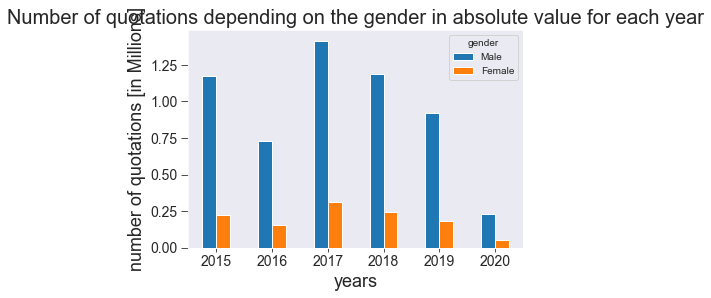

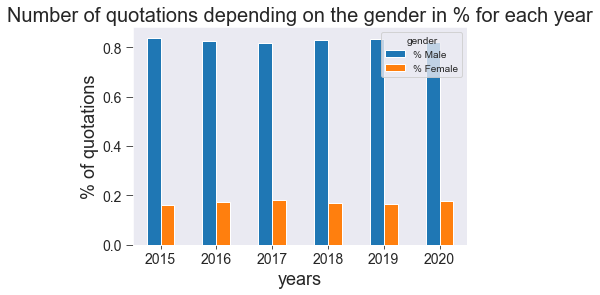

In [128]:
gender_all_years_extended = gender_all_years_extension(df_list)
plot_gender_all_years(gender_all_years_extended)

**Observation** : 
- G

##### Statistical tests over the years

**Observation** : 
- The pvalue...

## Age

In [42]:
#To be run once only !
bins = np.arange(0,110,step=10)
for df in df_list:
    df = compute_age_and_agerange(df, bins)

0
1
2
3
4
5


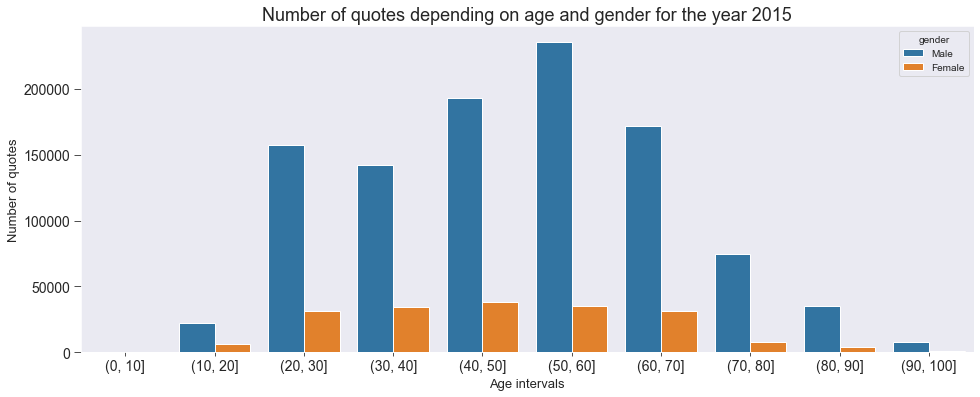

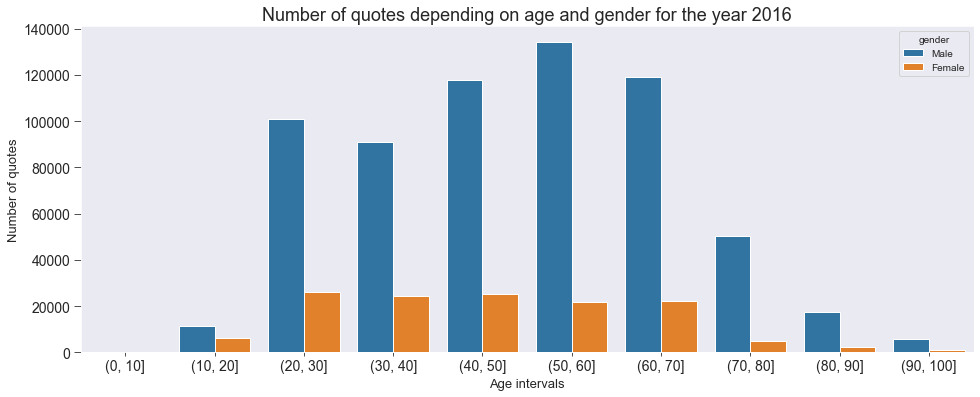

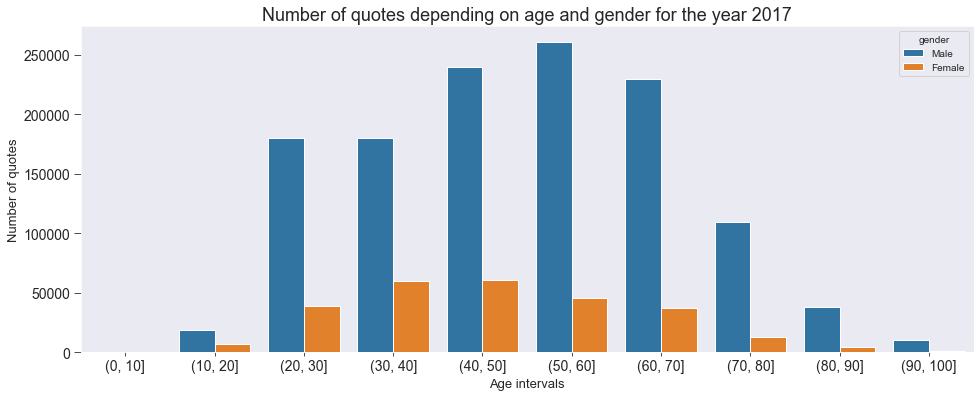

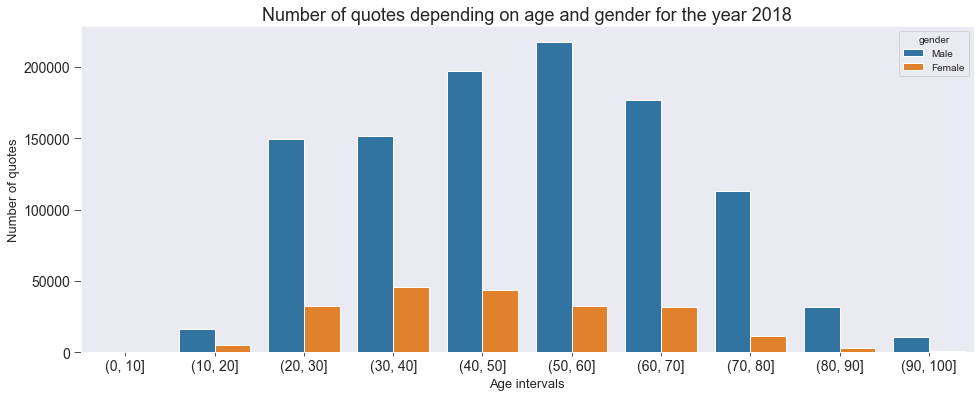

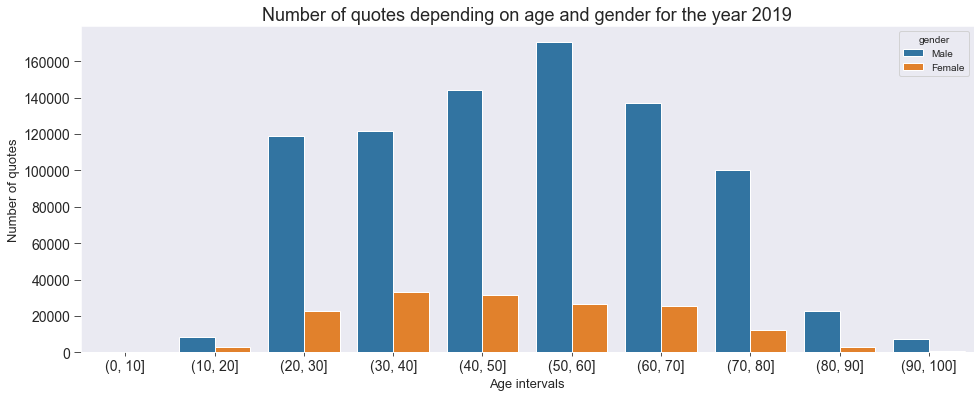

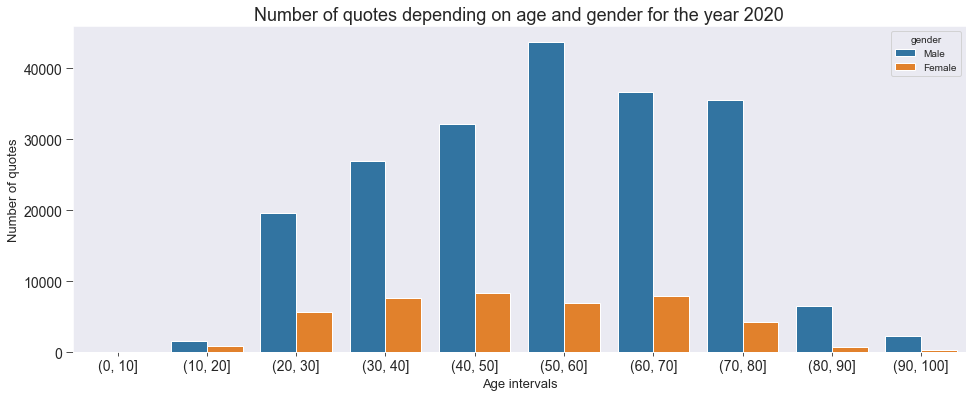

In [43]:
for df in df_list:
    plot_quotes_age(df, age_threshold = 100)

**Observation** :
- For both gender, the distribution seems to be normal (a test is to be run to verify this observation)
- Males of age from 50 to 60 seem to be more quoted for each year 
- Females of age from 30 to 40 seem to be more quoted for each year 


**Statistical test for the age** : 

In [ ]:
#code lines of ART for t test

In [ ]:
#test to see if the distribution is normal

## Countries

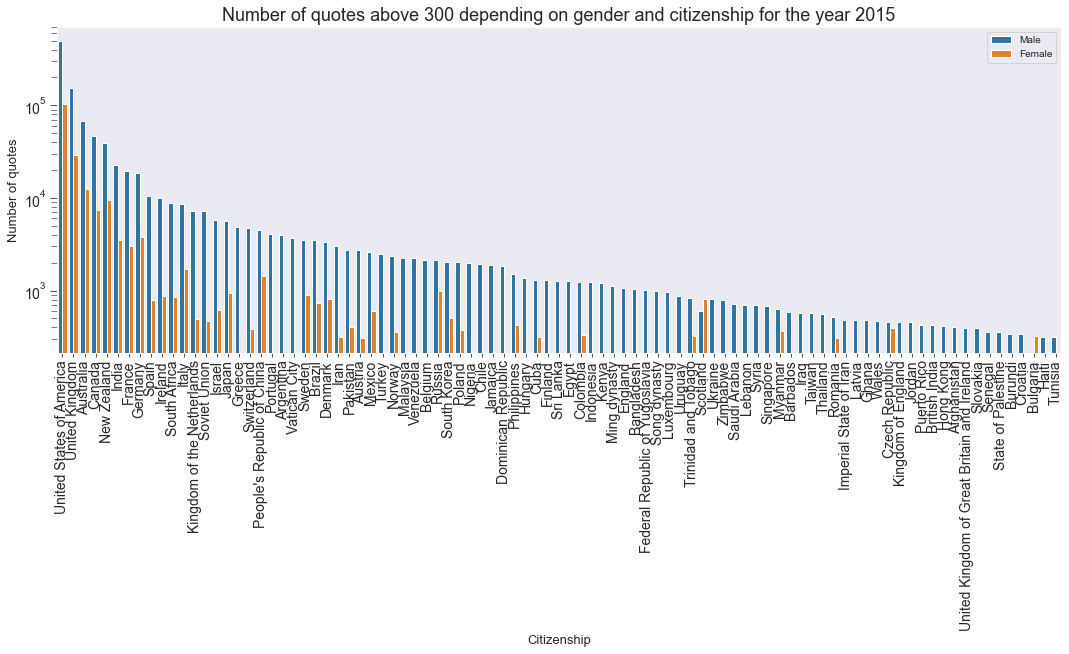

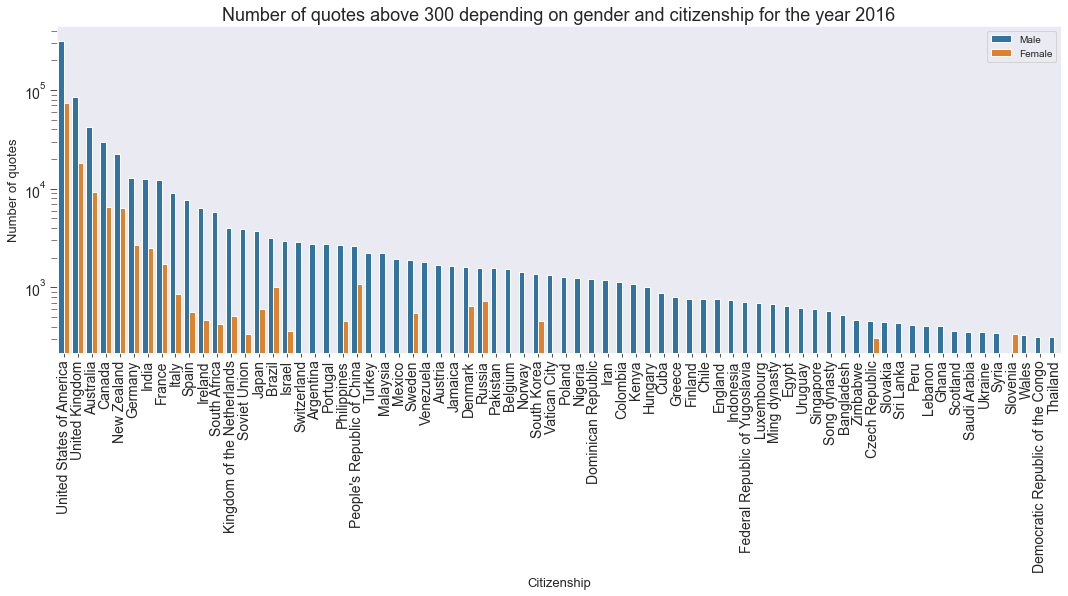

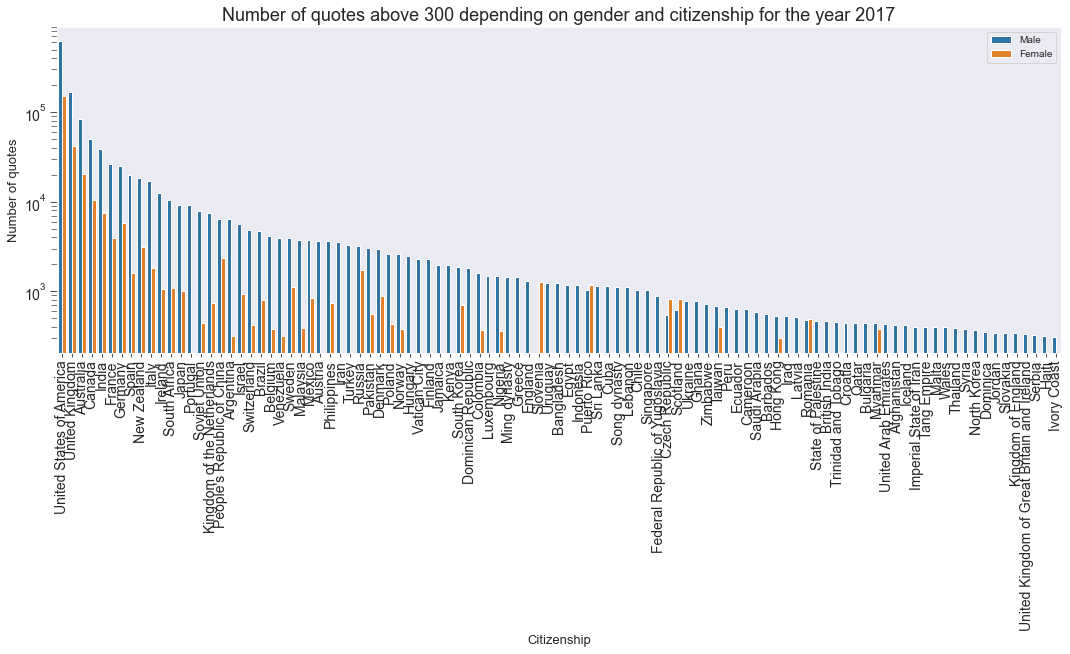

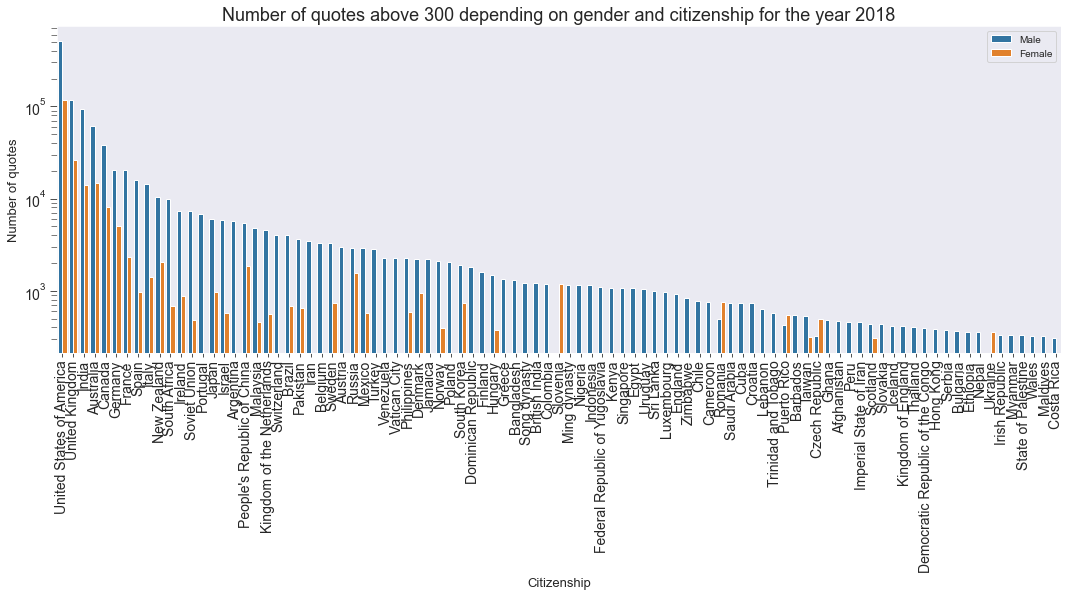

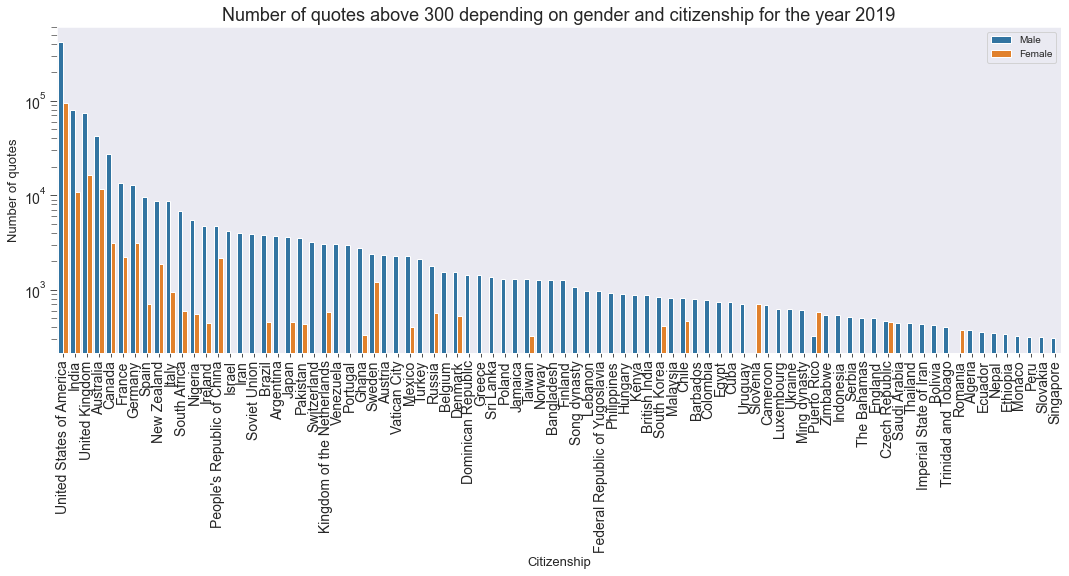

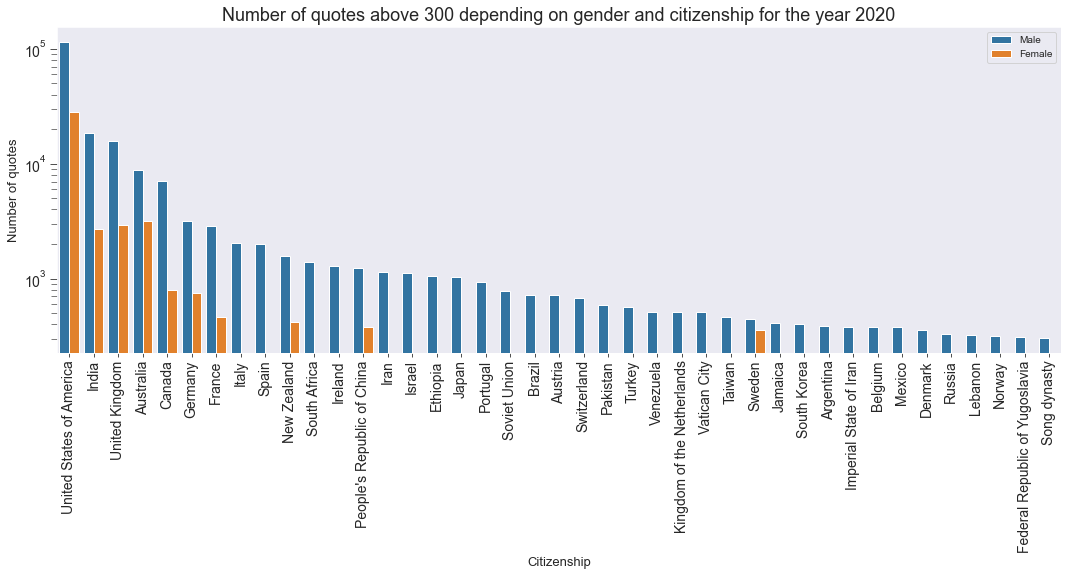

In [44]:
for df in df_list:
    plot_quotes_country(df, threshold_nber = 300)

**Observation** :
- Vast majority of countries quotes more males than females
- Few exceptions such as 


## Continents

In [58]:
for df in df_list:
    df["Continent"] = add_continent(df, countries_to_continent)

Index(['speaker', 'qids', 'quoteID', 'urls', 'sitenames', 'domain', 'tags',
       'quotation', 'gender', 'citizenship', 'Description', 'date_of_birth',
       'age', 'age_range', 'Continent'],
      dtype='object')
Index(['speaker', 'qids', 'quoteID', 'urls', 'sitenames', 'domain', 'tags',
       'quotation', 'gender', 'citizenship', 'Description', 'date_of_birth',
       'age', 'age_range', 'Continent'],
      dtype='object')
Index(['speaker', 'qids', 'quoteID', 'quotation', 'urls', 'sitenames',
       'domain', 'tags', 'gender', 'citizenship', 'Description',
       'date_of_birth', 'age', 'age_range', 'Continent'],
      dtype='object')
Index(['speaker', 'qids', 'quoteID', 'urls', 'sitenames', 'domain', 'tags',
       'quotation', 'gender', 'citizenship', 'Description', 'date_of_birth',
       'age', 'age_range', 'Continent'],
      dtype='object')
Index(['speaker', 'qids', 'quoteID', 'urls', 'sitenames', 'domain', 'tags',
       'quotation', 'gender', 'citizenship', 'Description', 

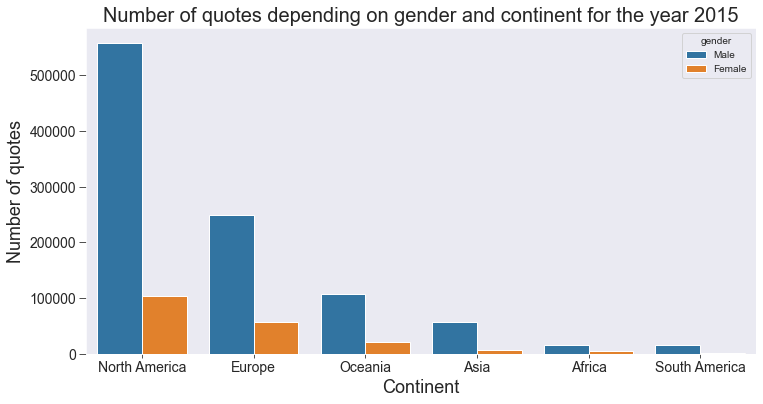

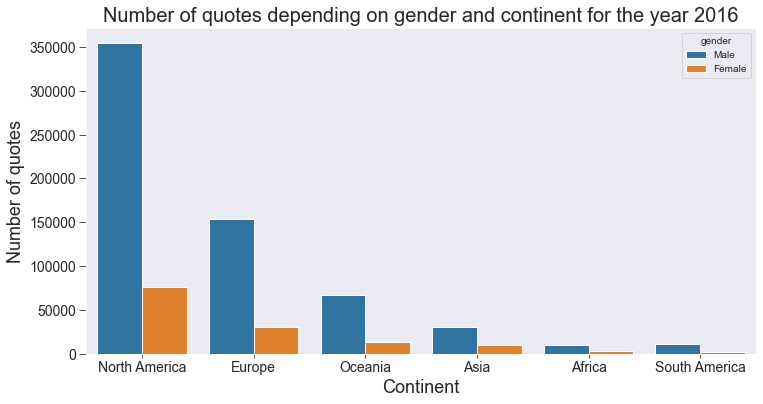

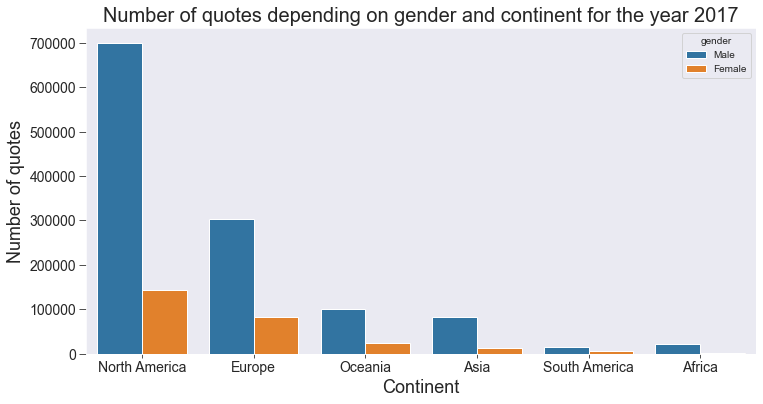

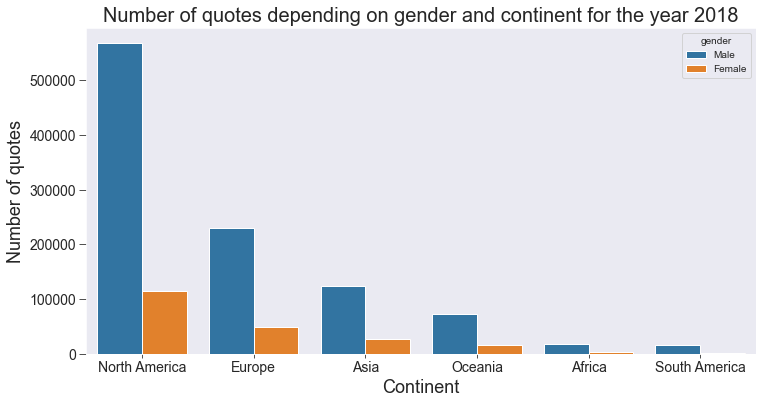

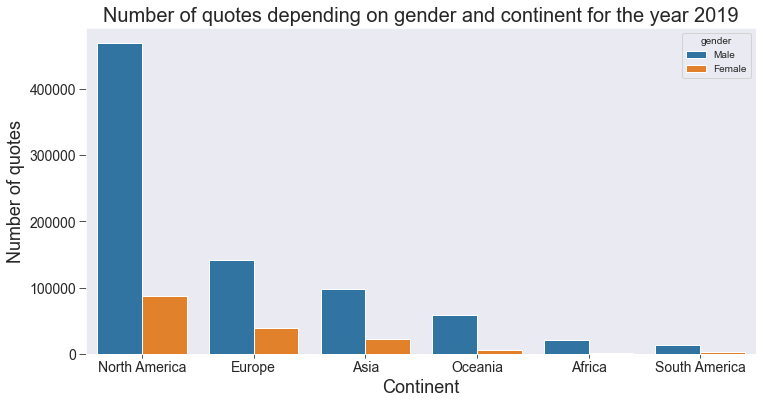

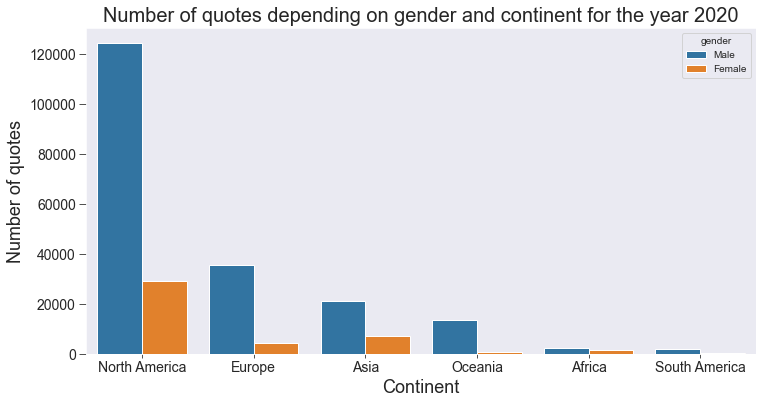

In [60]:
for df in df_list:
    plot_quotes_continent(df)

##### Observation :



## Number of quotes per media

In [61]:
#to be improved in the future to keep all the sitenames and not the first one only

#To be run once only !
for df in df_list:
    df["sitenames"] = extract_element_from_series(df['sitenames'])

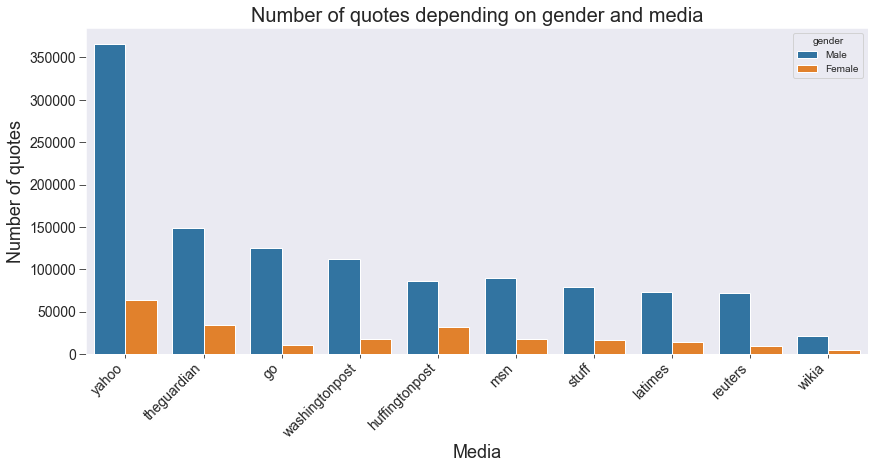

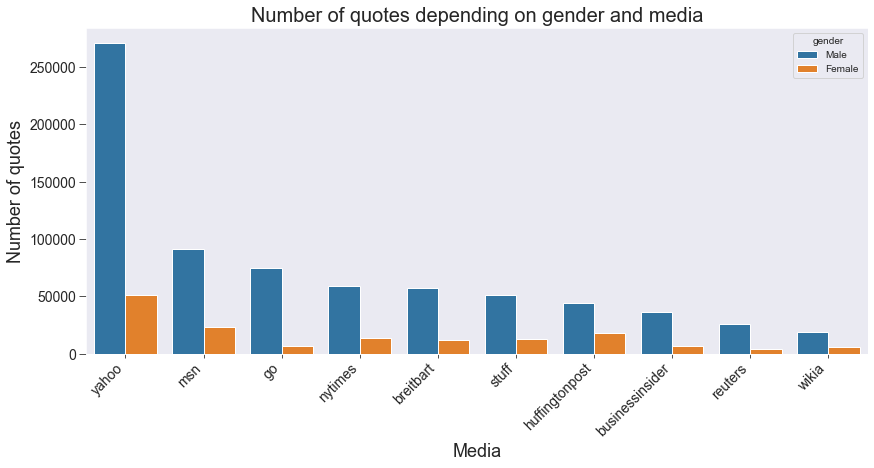

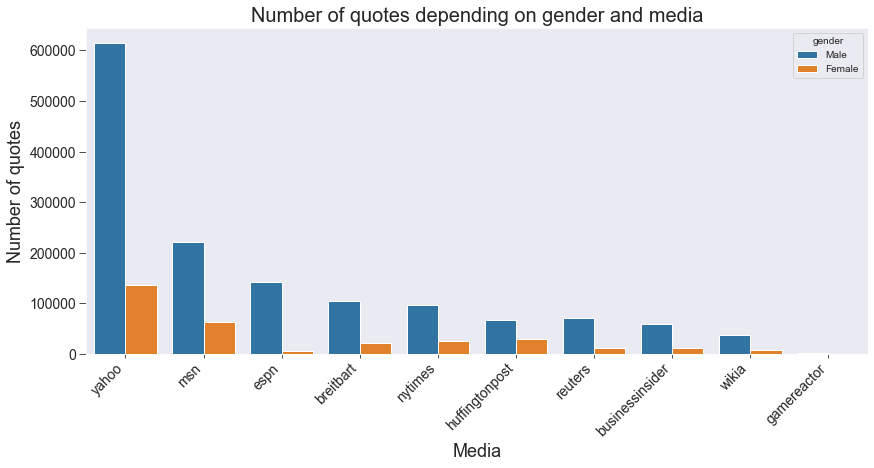

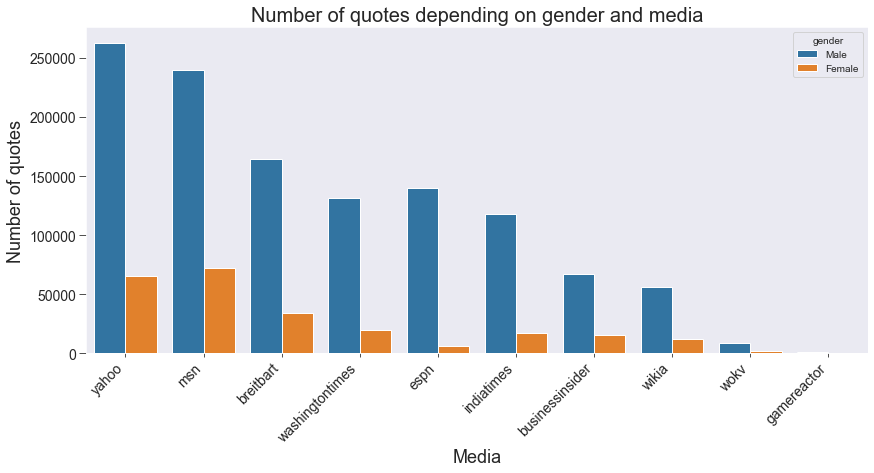

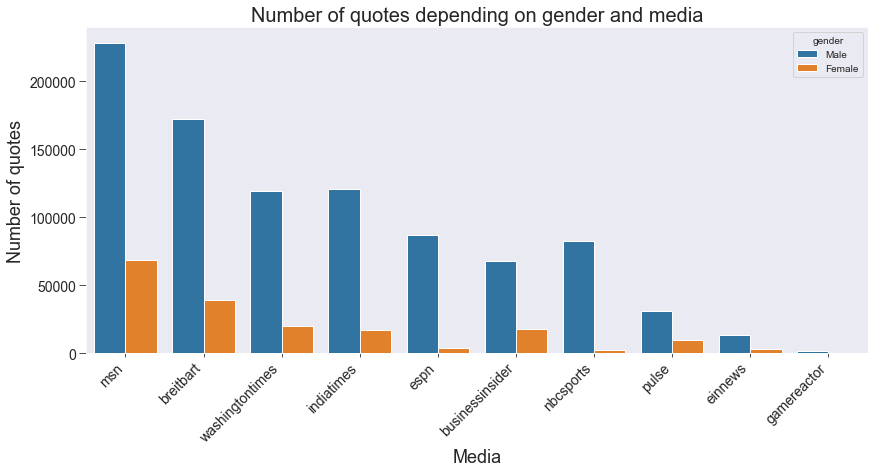

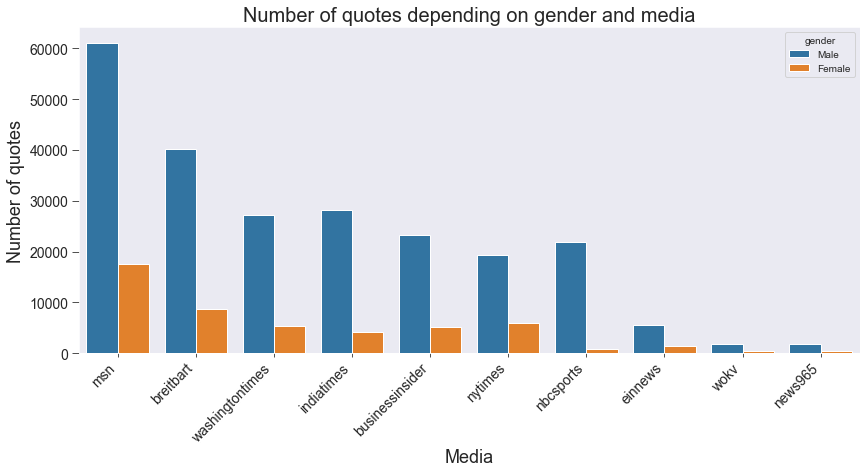

In [62]:
for df in df_list:
    plot_quotes_media(df)

##### Observation :



## Number of quotes per category 

In [71]:
for df in df_list:
    df['tags'] = transform_tags(df)

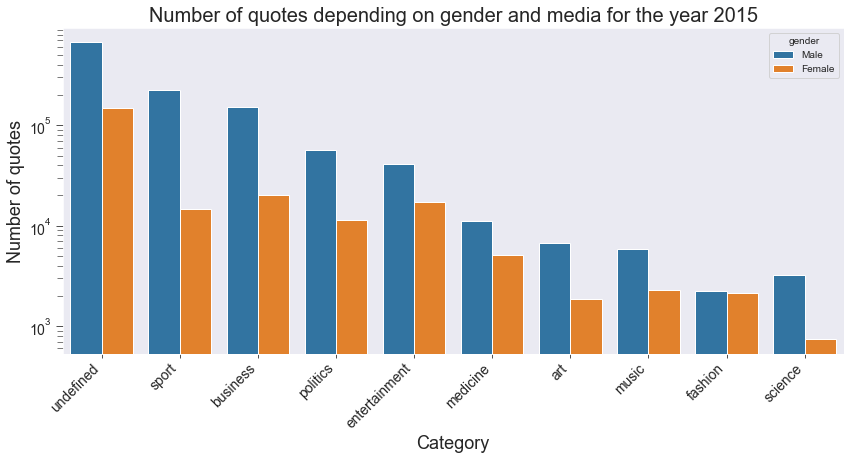

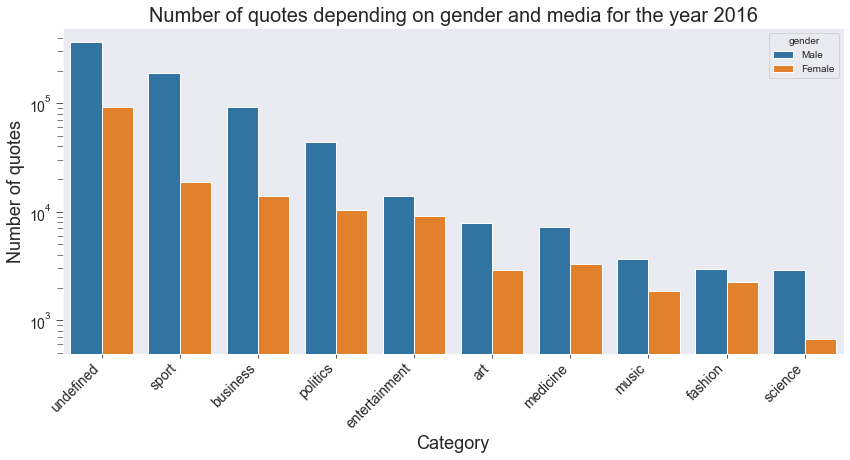

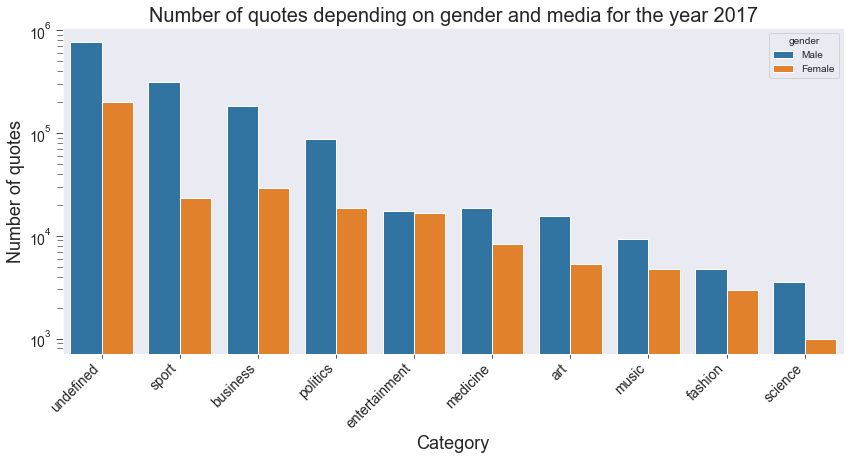

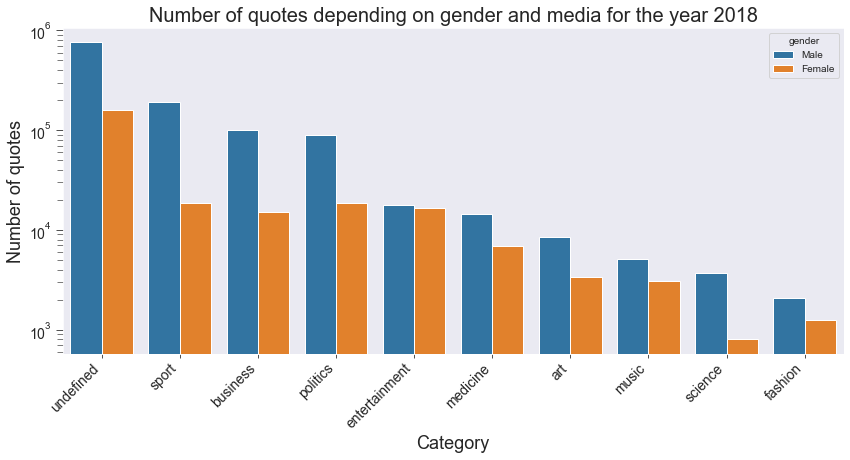

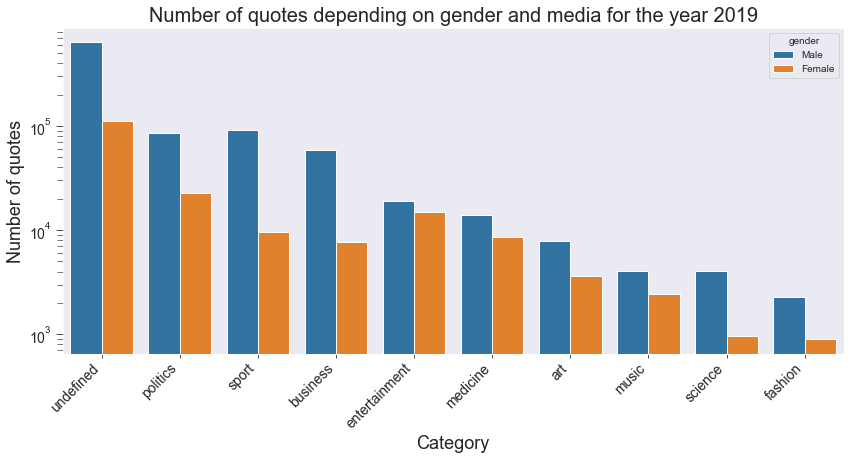

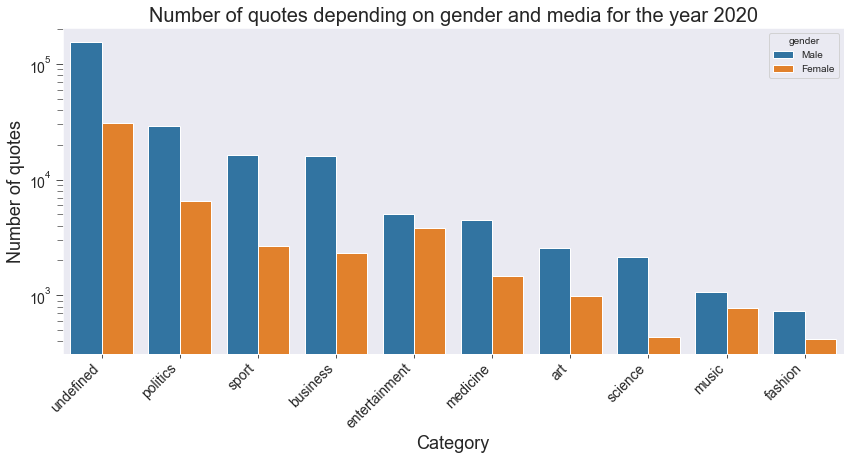

In [74]:
for df in df_list:
    plot_quotes_categories(df)

## Length of quotes

In [98]:
for df in df_list:
    df = compute_quotation_length(df)

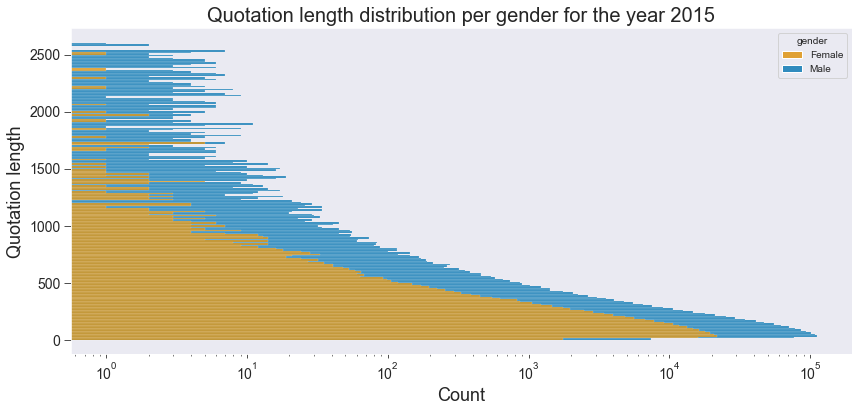

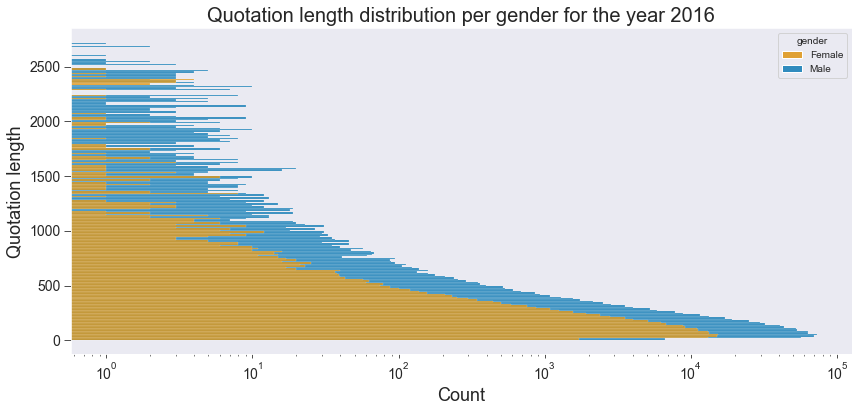

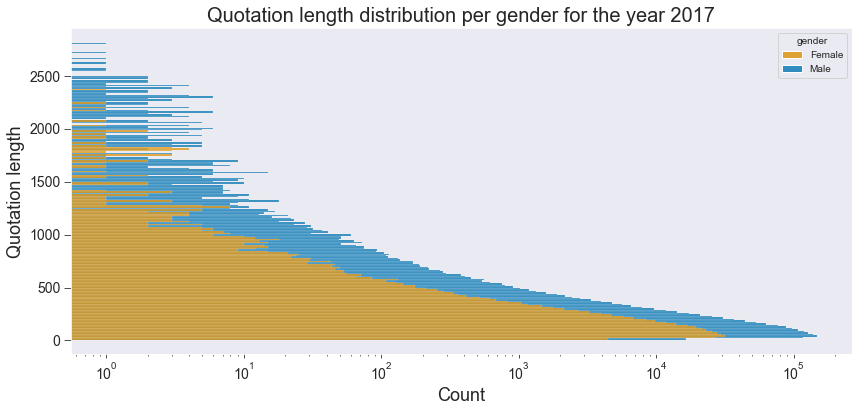

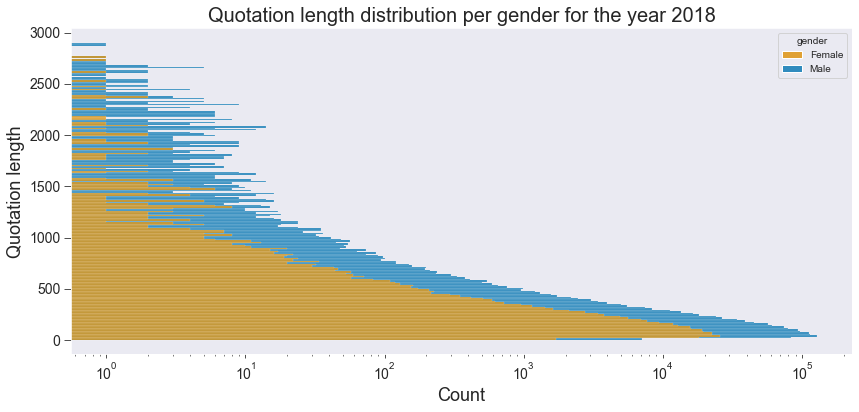

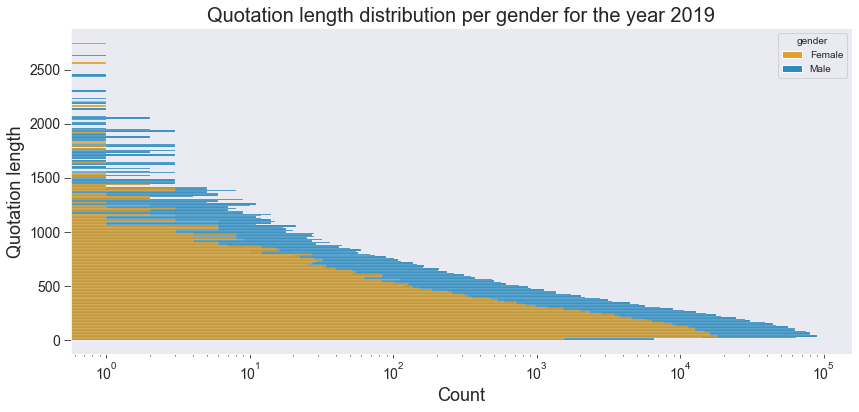

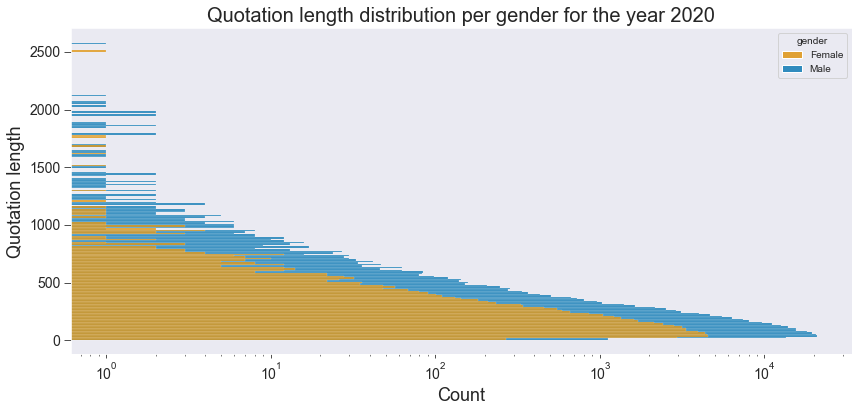

In [135]:
for df in df_list:
    plot_quotes_distribution(df)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 576x720 with 0 Axes>

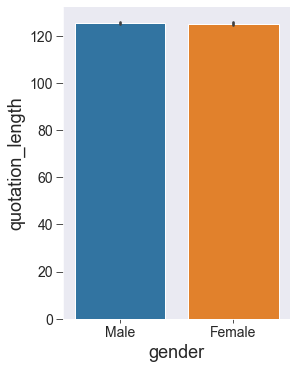

In [126]:
plot_avg_quotes_length(df_2020, conf_int=95)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 864x432 with 0 Axes>

<Figure size 576x720 with 0 Axes>

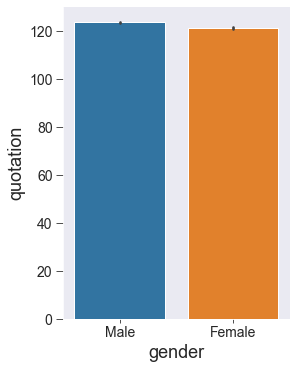

In [88]:
for df in df_list:
    plot_avg_quotes_length(df, conf_int=95)

In [142]:
print('Null hypothesis : the length of the quotes in the most popular media is independant of the gender')
for df in df_list:
    year = df['quoteID'][0][0:4]
    
    print('\nFor the year '+ year, ':')
    pvalue = T_test(df['quotation_length'][df['gender'] == 'Female'], 
                    df['quotation_length'][df['gender'] == 'Male'])
    if pvalue < 0.05:
        print('The p-value of this statistical test amounts to', np.round(pvalue,4), "we therefore have to reject the null hypothesis.")
    else:
        print('The p-value of this statistical test amounts to', np.round(pvalue,4), "we therefore cannot reject the null hypothesis.")

Null hypothesis : the length of the quotes in the most popular media is independant of the gender

For the year 2015 :
The p-value of this statistical test amounts to 0.0 we therefore have to reject the null hypothesis.

For the year 2016 :
The p-value of this statistical test amounts to 0.0 we therefore have to reject the null hypothesis.

For the year 2017 :
The p-value of this statistical test amounts to 0.0017 we therefore have to reject the null hypothesis.

For the year 2018 :
The p-value of this statistical test amounts to 0.0 we therefore have to reject the null hypothesis.

For the year 2019 :
The p-value of this statistical test amounts to 0.0 we therefore have to reject the null hypothesis.

For the year 2020 :
The p-value of this statistical test amounts to 0.3833 we therefore cannot reject the null hypothesis.


**Interpretation** : 
-

## Quotes per journals

#### **Basic data analysis**

NOTE FOR US Check on the read me for plots and stuff to do:

*Note*: For this hand in we will not look into questions that are computed over the years since we only focus on a subset of the whole data 

Comparison of number of male versus female quotes
USE FUNCTIONS TO PLOT TO RUN IT FOR EACH YEAR
Lisa : 
- Overall difference in count of males versus females, over all years.
- Overall count of male versus female quotes, per year.
- Overall count of male versus female quotes, per category.
- Overall count of male versus female quotes, per year and per category.
- Overall count of male versus female quotes, per country/geographical location.
- Overall count of male versus female quotes, per year and per country/geographical location.
Arthur : 
- Compare length of quotes 

Tests for statistical significance
Arthur : 
- Perform statistical tests to see if the difference between counts of males and females per year is statistically significant.
- Perform statistical tests to see if the difference per year and per category is statistically significant.
- Perform statistical tests to see if the difference per year and per location is statistically significant.
